In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

import vo, vio
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.1 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

In [3]:
# RUN THIS CELL FOR KITTI
kitti_base_path = '/home/jlee/Downloads'
kitti_date = '2011_09_26'
kitti_drive = '0022'

# Read KITTI data
dataset_info = utils.read_data_kitti('/home/jlee/Downloads', '2011_09_26', '0022')

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

T_inC_ofB = dataset_info['cam0_extrinsics']

In [4]:
def imu_collate(data):
    w_x = np.stack([d['w_x'] for d in data])
    w_y = np.stack([d['w_y'] for d in data])
    w_z = np.stack([d['w_z'] for d in data])

    a_x = np.stack([d['a_x'] for d in data])
    a_y = np.stack([d['a_y'] for d in data])
    a_z = np.stack([d['a_z'] for d in data])

    acc_meas = np.vstack([a_x, a_y, a_z]).T
    gyr_meas = np.vstack([w_x, w_y, w_z]).T
    
    return acc_meas, gyr_meas

def groundtruth_collate(data):
    q_x = np.stack([d['groundtruth']['q_x'] for d in data])
    q_y = np.stack([d['groundtruth']['q_y'] for d in data])
    q_z = np.stack([d['groundtruth']['q_z'] for d in data])
    q_w = np.stack([d['groundtruth']['q_w'] for d in data])

    v_x = np.stack([d['groundtruth']['v_x'] for d in data])
    v_y = np.stack([d['groundtruth']['v_y'] for d in data])
    v_z = np.stack([d['groundtruth']['v_z'] for d in data])

    p_x = np.stack([d['groundtruth']['p_x'] for d in data])
    p_y = np.stack([d['groundtruth']['p_y'] for d in data])
    p_z = np.stack([d['groundtruth']['p_z'] for d in data])

    R_inW_ofB = R.from_quat(np.vstack([q_x, q_y, q_z, q_w]).T)
    v_inW_ofB = np.vstack([v_x, v_y, v_z]).T
    p_inW_ofB = np.vstack([p_x, p_y, p_z]).T
    
    return R_inW_ofB, v_inW_ofB, p_inW_ofB

### Create random generator

In [5]:
rng = utils.create_rng(None)

seeding RNG with 3927496354


### Create image keypoint feature extractor

In [6]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [7]:
chosen_index = 5
advance = 5

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vio.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                         first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vio.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                         second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

acc_meas, gyr_meas = imu_collate(dataset_info['visual_inertial_data'])
R_inW_ofB, v_inW_ofB, p_inW_ofB = groundtruth_collate(dataset_info['visual_inertial_data'])

# Perform two-view reconstruction
R_inC_ofB = T_inC_ofB[:3,:3]
p_inC_ofB = T_inC_ofB[:3,-1]

R_inC_ofW = R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T
p_inC_ofW = - R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx] + p_inC_ofB
tracks = vio.vo_2view(views, matching_threshold, cam0_K, R_inC_ofW, p_inC_ofW, rng, use_opencv=False)

found 21 good matches
found 21 inliers



REPROJECTION ERRORS
 Image  0 (   21 points) : (mean, std, max, min) = (  0.11,   0.30,   1.45,   0.00)
 Image (raw reprojection)  0 (   21 points) : (mean, std, max, min) = (  0.11,   0.30,   1.45,   0.00)
 Image  1 (   21 points) : (mean, std, max, min) = (  0.11,   0.31,   1.50,   0.00)
 Image (raw reprojection)  1 (   21 points) : (mean, std, max, min) = (  0.11,   0.31,   1.50,   0.00)


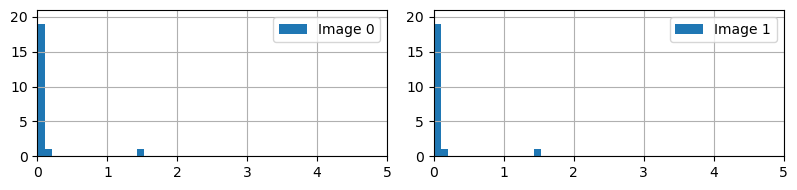

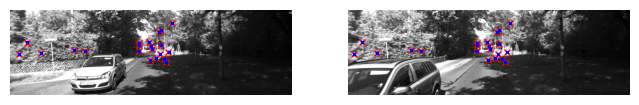

In [8]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

In [9]:
T_inB0_ofW = np.block([[R_inW_ofB[first_frame_idx].as_matrix().T, - R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC0_ofW = T_inC_ofB @ T_inB0_ofW

T_inB1_ofW = np.block([[R_inW_ofB[second_frame_idx].as_matrix().T, - R_inW_ofB[second_frame_idx].as_matrix().T @ p_inW_ofB[second_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC1_ofW = T_inC_ofB @ T_inB1_ofW

T_inC0_ofW = None
T_inC1_ofW = None

views, tracks, initial_values, results = vio.vio_nonlinear_optimize(views, tracks, acc_meas[first_frame_idx:second_frame_idx], gyr_meas[first_frame_idx:second_frame_idx], 
                                                                    cam0_K, T_inC_ofB, max_reprojection_err,
                                                                    v_inW_ofB[first_frame_idx], v_inW_ofB[second_frame_idx],
                                                                    T_inC0_ofW, T_inC1_ofW)

[2024-05-06 11:10:19.609] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5623500544.637/0.000/455319840.000, rel reduction: 0.91903
[2024-05-06 11:10:19.612] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 455319853.491/0.000/755622.812, rel reduction: 0.99834
[2024-05-06 11:10:19.615] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 755622.782/0.000/90.446, rel reduction: 0.99988
[2024-05-06 11:10:19.618] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 90.446/0.000/57.092, rel reduction: 0.36877
[2024-05-06 11:10:19.620] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 57.092/0.000/52.844, rel reduction: 0.07440
[2024-05-06 11:10:19.623] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 52.844/0.000/45.819, rel reduction: 0.13294
[2024-05-06 11:10:19.625] [info] LM<sym::Optimize> [iter    6] lambda: 1.000

Evaluate change in position between frames

In [10]:
# Symforce - Initial values
R_inW_ofC0_ini = results.initial_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_ini = - R_inW_ofC0_ini @ results.initial_values['T_inC0_ofW'].t

R_inW_ofB0_ini = R_inW_ofC0_ini @ R_inC_ofB
p_inW_ofB0_ini = R_inW_ofC0_ini @ p_inC_ofB + p_inW_ofC0_ini

R_inW_ofC1_ini = results.initial_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_ini = - R_inW_ofC1_ini @ results.initial_values['T_inC1_ofW'].t

R_inW_ofB1_ini = R_inW_ofC1_ini @ R_inC_ofB
p_inW_ofB1_ini = R_inW_ofC1_ini @ p_inC_ofB + p_inW_ofC1_ini

# Symforce - Optimized values
R_inW_ofC0_sf = results.optimized_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_sf = - R_inW_ofC0_sf @ results.optimized_values['T_inC0_ofW'].t

R_inW_ofB0_sf = R_inW_ofC0_sf @ R_inC_ofB
p_inW_ofB0_sf = R_inW_ofC0_sf @ p_inC_ofB + p_inW_ofC0_sf

R_inW_ofC1_sf = results.optimized_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_sf = - R_inW_ofC1_sf @ results.optimized_values['T_inC1_ofW'].t

R_inW_ofB1_sf = R_inW_ofC1_sf @ R_inC_ofB
p_inW_ofB1_sf = R_inW_ofC1_sf @ p_inC_ofB + p_inW_ofC1_sf

# ground truth
R_inW_ofB0_gt = R_inW_ofB[first_frame_idx].as_matrix()
p_inW_ofB0_gt = p_inW_ofB[first_frame_idx]
v_inW_ofB0_gt = v_inW_ofB[first_frame_idx]

R_inW_ofB1_gt = R_inW_ofB[second_frame_idx].as_matrix()
p_inW_ofB1_gt = p_inW_ofB[second_frame_idx]
v_inW_ofB1_gt = v_inW_ofB[second_frame_idx]

Error evaluation on final results

In [11]:
p_inW_ofB0toB1_ini = p_inW_ofB1_ini - p_inW_ofB0_ini
R_inB1_ofB0_ini = R_inW_ofB1_ini.T @ R_inW_ofB0_ini

p_inW_ofB0toB1_sf = p_inW_ofB1_sf - p_inW_ofB0_sf
R_inB1_ofB0_sf = R_inW_ofB1_sf.T @ R_inW_ofB0_sf

v_inW_ofB0toB1_gt = v_inW_ofB1_gt - v_inW_ofB0_gt
p_inW_ofB0toB1_gt = p_inW_ofB1_gt - p_inW_ofB0_gt
R_inB1_ofB0_gt = R_inW_ofB1_gt.T @ R_inW_ofB0_gt

dR_err_ini = R.from_matrix(R_inB1_ofB0_ini.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
dR_err_sf = R.from_matrix(R_inB1_ofB0_sf.T @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR: {dR_err_ini} (init.) --> {dR_err_sf} (optm.) [deg] (xyz)')

dp_err_ini = p_inW_ofB0toB1_ini - p_inW_ofB0toB1_gt
dp_err_sf = p_inW_ofB0toB1_sf - p_inW_ofB0toB1_gt
print(f'dp: {np.linalg.norm(dp_err_ini):.2f} (init.) --> {np.linalg.norm(dp_err_sf):.2f} (optm.) [m] (rel err: {np.linalg.norm(dp_err_sf)/np.linalg.norm(p_inW_ofB0toB1_gt)*100:.2f} [%])')

dR: [-0.00437121 -0.02048341  0.01800734] (init.) --> [-0.07962515 -0.06483328  0.06562511] (optm.) [deg] (xyz)
dp: 0.50 (init.) --> 0.34 (optm.) [m] (rel err: 47.36 [%])


(Optional) Error evaluation on preintegrated results

In [12]:
gravity = results.initial_values['gravity']
dt_01 = results.initial_values['dt_01']
dR_01 = results.initial_values['dR_01']
dv_01 = results.initial_values['dv_01']
dp_01 = results.initial_values['dp_01']

dR_err_pi = R.from_matrix(dR_01 @ R_inB1_ofB0_gt).as_euler('xyz', degrees=True)
print(f'dR_preintegrated: {dR_err_pi} [deg] (xyz)')

v_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dv_01 + gravity * dt_01
dv_err_pi = v_inW_ofB0toB1_pi - v_inW_ofB0toB1_gt

print(f'dv_preintegrated: {np.linalg.norm(v_inW_ofB0toB1_pi):.2f} [m/s] (abs err: {np.linalg.norm(dv_err_pi):.2f} [m/s], rel err: {np.linalg.norm(dv_err_pi)/np.linalg.norm(v_inW_ofB0toB1_gt)*100:.2f} [%])')

p_inW_ofB0toB1_pi = R_inW_ofB0_gt @ dp_01 + v_inW_ofB0_gt * dt_01 + 0.5 * gravity * dt_01 ** 2
dp_err_pi = p_inW_ofB0toB1_pi - p_inW_ofB0toB1_gt

print(f'dp_preintegrated: {np.linalg.norm(p_inW_ofB0toB1_pi):.2f} [m] (abs err: {np.linalg.norm(dp_err_pi):.2f} [m], rel err: {np.linalg.norm(dp_err_pi)/np.linalg.norm(p_inW_ofB0toB1_gt)*100:.2f} [%])')


dR_preintegrated: [-0.02108526 -0.01260272 -0.00335856] [deg] (xyz)
dv_preintegrated: 0.16 [m/s] (abs err: 0.04 [m/s], rel err: 20.72 [%])
dp_preintegrated: 0.27 [m] (abs err: 0.47 [m], rel err: 65.22 [%])



REPROJECTION ERRORS
 Image  0 (   10 points) : (mean, std, max, min) = (  0.19,   0.13,   0.50,   0.06)
 Image (raw reprojection)  0 (   10 points) : (mean, std, max, min) = (  0.19,   0.13,   0.50,   0.06)
 Image  1 (   10 points) : (mean, std, max, min) = (  0.19,   0.13,   0.50,   0.06)
 Image (raw reprojection)  1 (   10 points) : (mean, std, max, min) = (  0.19,   0.13,   0.50,   0.06)


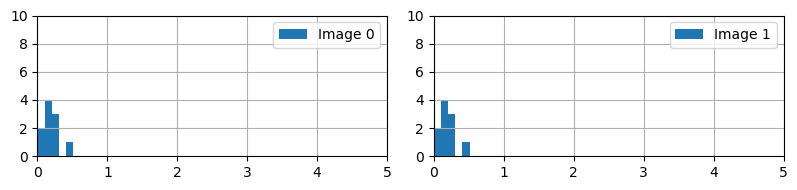

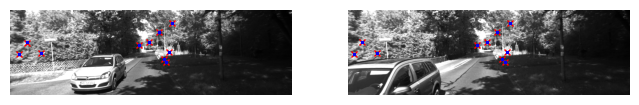

In [13]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [14]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)

KeyError: 'R_inB_ofA'

### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [ ]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)